In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import json
import random
import numpy as np
import pandas as pd
import itertools
import scipy
import gc
import cv2

from pathlib import Path
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import colors as colors_mat
from scipy.ndimage import label, generate_binary_structure
from numpy.lib.stride_tricks import as_strided
from itertools import product
from scipy.spatial.distance import cdist
from scipy.signal import convolve2d
from collections import Counter

DEBUG = True # Active logging, printing, etc. False when committing to the LB.  

In [3]:
start_time = time.time()
print("Load Initial Data ...")

data_path = Path('')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
testing_path = data_path / 'test'

training_tasks = sorted(os.listdir(training_path))
evaluation_tasks = sorted(os.listdir(evaluation_path))
testing_tasks = sorted(os.listdir(testing_path))
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')

print("--- %s seconds ---" % (time.time() - start_time))

Load Initial Data ...
--- 0.026468992233276367 seconds ---


In [4]:
start_time = time.time()
print("Load Data Functions ...")

def flattener(pred):
    
    str_pred = str([row for row in pred.tolist()])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    
    return str_pred

def build_trainlist(task):
    
    task_data = []
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]).astype('uint8'), np.array(t["output"]).astype('uint8')        
        list.append(task_data, (t_in.copy(), t_out.copy()))
    
    return task_data

def build_testlist(task):
    
    task_data = []
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"]).astype('uint8')       
        list.append(task_data, (t_in.copy()))
    
    return task_data

def load_data(p, phase=None):
    
    if phase in {'training', 'test', 'evaluation'}:
        p = data_path / phase / p
    
    task = json.loads(Path(p).read_text())
    dict_vals_to_np = lambda x: { k : np.array(v) for k, v in x.items() }
    assert set(task) == {'test', 'train'}
    res = dict(test=[], train=[])
    
    for t in task['train']:
        assert set(t) == {'input', 'output'}
        res['train'].append(dict_vals_to_np(t))
    for t in task['test']:
        res['test'].append(dict_vals_to_np(t))
        
    return res

print("--- %s seconds ---" % (time.time() - start_time))

Load Data Functions ...
--- 0.0010380744934082031 seconds ---


In [5]:
start_time = time.time()
print("Load Data Files ...")

train_task_data = []
for i in range(0, 400):
    task = load_data(training_tasks[i], phase='training')
    list.append(train_task_data, task)

eval_task_data = []
for i in range(0, 400):
    task = load_data(evaluation_tasks[i], phase='evaluation')
    list.append(eval_task_data, task)

test_task_data = []
for i in range(0, 100):
    task = load_data(testing_tasks[i], phase='test')
    list.append(test_task_data, task)
    
print("--- %s seconds ---" % (time.time() - start_time))

Load Data Files ...
--- 0.8137290477752686 seconds ---


In [6]:
start_time = time.time()
print("Load Checking Functions")

cmap = colors_mat.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors_mat.Normalize(vmin=0, vmax=9)
num2color = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]
color2num = {c: n for n, c in enumerate(num2color)}

def plot_one(task, ax, i,train_or_test,input_or_output):
    
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+ input_or_output)
    
def plot_task(task):

    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i],i,'train','input')
        plot_one(task, axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(task, axs[0],0,'test','input')
        plot_one(task, axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(task, axs[0,i],i,'test','input')
            plot_one(task, axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show()

def check_p(task, pred_func):
    
    fig_num = 0
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(3, n, figsize=(4*n,12), dpi=50)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # All Data for Task
    train_data = build_trainlist(task)
    test_data = build_testlist(task)
    task_data = Task(train_data, test_data)
    
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]).astype('uint8'), np.array(t["output"]).astype('uint8')   
        t_pred = pred_func(t_in)
        
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        axs[2][fig_num].imshow(t_pred, cmap=cmap, norm=norm)
        axs[2][fig_num].set_title(f'Train-{i} pred')
        axs[2][fig_num].set_yticks(list(range(t_pred.shape[0])))
        axs[2][fig_num].set_xticks(list(range(t_pred.shape[1])))
        fig_num += 1
        
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]).astype('uint8'), np.array(t["output"]).astype('uint8')
        t_pred = pred_func(t_in)
        
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        axs[2][fig_num].imshow(t_pred, cmap=cmap, norm=norm)
        axs[2][fig_num].set_title(f'Test-{i} pred')
        axs[2][fig_num].set_yticks(list(range(t_pred.shape[0])))
        axs[2][fig_num].set_xticks(list(range(t_pred.shape[1])))
        fig_num += 1

print("--- %s seconds ---" % (time.time() - start_time))

Load Checking Functions
--- 0.0016219615936279297 seconds ---


In [7]:
start_time = time.time()
print("Load DSL Helper Functions (Main)")

def get_neighbors(grid, i, j):
    
    nbh = lambda x, i, j: { 
        (ip, jp) : x[i+ip, j+jp] 
            for ip, jp in product([1, -1, 0], repeat=2) 
                if 0 <= i+ip < x.shape[0] and 0 <= j+jp < x.shape[1]
    }
        
    nbh_data = nbh(grid, i, j)
    nbh_values = [(1, 1), (1, -1), (1, 0), (-1, 1), (-1, -1), 
                  (-1, 0), (0, 1), (0, -1), (0, 0)]

    for val in nbh_values:
        if val not in nbh_data:
            nbh_data[val] = 0
    
    return nbh_data

def get_background_color(grid):
    
    try:    
        background_color = 0
        cnt = np.bincount(grid.flatten())[1:]
        bg_color = [i + 1 for i, x in enumerate(cnt) if x == max(cnt)][0]
        if np.nonzero(cnt)[0].shape[0] >= 2:
            if max(cnt) >= (grid.shape[0] * grid.shape[1] * 0.25):
                background_color = bg_color
        return background_color    
    
    except:
        return 0
    
# return a list with all the colors available in grid
def get_unique_colors(grid):
        return np.unique(grid).tolist()
    
# Return a dictionary color:percentage, for instance: {0: 0.666,1: 0.333, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
def color_percentage(grid):
    
    n_elements = grid.shape[0] * grid.shape[1]
    if ( n_elements <= 0):
        raise ValueError("n_elements <= 0")
    unique, counts = np.unique(grid, return_counts=True)
    if not (all(j < 10 for j in unique)):
        raise ValueError("Uknown color! ", j)
        
    percentages =  dict(zip(unique, counts))
    for color in range(0,10):
        if color not in percentages.keys():
            percentages[color] = 0.0
    percentages.update((x, y*1.0/n_elements) for x, y in percentages.items())

    return percentages
    
print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Helper Functions (Main)
--- 0.0009763240814208984 seconds ---


In [8]:
start_time = time.time()
print("Load DSL Helper Functions (Detection)")
       
# Ensure No Duplicate Objects
def search_array(arr, arr_data):
    return next((True for elem in arr_data if np.array_equal(elem, arr)), False)

# Separate Objects by Distance
def object_detection_1(grid):
    
    # List of Objects
    object_list = []
    grid_copy = grid.copy()
    struct = generate_binary_structure(2, 2)
    labels, num_labels = label((grid_copy != 0), structure=struct)

    # Find Objects
    for i in range(0, num_labels):
        idx = np.column_stack(np.where(labels == i + 1))
        x_min = min([point[0] for point in idx])
        y_min = min([point[1] for point in idx])
        x_max = max([point[0] for point in idx])
        y_max = max([point[1] for point in idx])

        object_data = {}
        object_data['coords'] = idx
        object_data['obj'] = grid_copy[x_min: x_max + 1, y_min: y_max + 1]
        list.append(object_list, object_data)

    return object_list
        
# Separate Objects by Color/Distance
def object_detection_2(grid):
    
    # List of Objects
    object_list = []
    grid_copy = grid.copy()
    struct = generate_binary_structure(2, 2)
    
    # Ensure Colors != Background
    grid_colors = np.unique(grid_copy)
    bg_color = get_background_color(grid_copy)
    grid_colors = [col for col in grid_colors if col not in [0, bg_color]]

    # Find Objects
    for color in grid_colors:
        labels, num_labels = label((grid_copy == color), structure=struct)
        for i in range(0, num_labels):
            idx = np.column_stack(np.where(labels == i + 1))
            x_min = min([point[0] for point in idx])
            y_min = min([point[1] for point in idx])
            x_max = max([point[0] for point in idx])
            y_max = max([point[1] for point in idx])

            object_data = {}
            object_data['coords'] = idx
            object_data['obj'] = grid_copy[x_min: x_max + 1, y_min: y_max + 1]
            list.append(object_list, object_data)
        
    return object_list

# Separate Layers in grid
def layer_detection(grid):
    
    # List of Layers
    layer_list = []
    grid_copy = grid.copy()
    grid_colors = np.unique(grid_copy)

    # Find Layers by Color
    for color in grid_colors:
        layer_copy = grid_copy.copy()
        layer_copy[layer_copy != color] = 0
        
        idx = []
        for i in range(0, grid_copy.shape[0]):
            for j in range(0, grid_copy.shape[1]):
                list.append(idx, [i, j])

        layer_data = {}
        layer_data['coords'] = np.array(idx)
        layer_data['obj'] = layer_copy
        list.append(layer_list, layer_data)
        
    return layer_list
      
# Separate Regions in grid
def region_detection(grid):
    
    # List of Regions
    region_list = []
    grid_copy = grid.copy()

    # Ensure Colors != Background
    grid_colors = np.unique(grid_copy)
    bg_color = get_background_color(grid_copy)
    grid_colors = [col for col in grid_colors if col not in [0, bg_color]]
    
    # Find Regions by Looking for Horizontal/Vertical Lines
    # Typically, there won't be any overlap between region lines/object colors
    for color in grid_colors:
        
        # Declare Splits
        vertical_splits = None
        horizontal_splits = None

        # Vertical Regions
        vertical_partition = np.zeros((grid_copy.shape[0], 1))       
        vertical_partition[:, 0] = color
        vertical_result = cv2.matchTemplate(
            grid_copy.astype(np.uint8), vertical_partition.astype(np.uint8), cv2.TM_SQDIFF)
        vertical_positions = np.argwhere(vertical_result < 0.001)

        # Horizontal Regions
        horizontal_partition = np.zeros((1, grid_copy.shape[1]))       
        horizontal_partition[0, :] = color
        horizontal_result = cv2.matchTemplate(
            grid_copy.astype(np.uint8), horizontal_partition.astype(np.uint8), cv2.TM_SQDIFF)
        horizontal_positions = np.argwhere(horizontal_result < 0.001)
                
        # Check if Horizontal/Vertical Partitions Exist
        if (len(vertical_positions) >= 1) or (len(horizontal_positions) >= 1):
            
            # Combine Vertical/Horizontal Regions
            vertical_splits = [-1] + [x[1] for x in vertical_positions]
            horizontal_splits = [-1] + [x[0] for x in horizontal_positions]
            
            # Get Vertical Split Ranges
            for i, v_split in enumerate(vertical_splits):
                end_split_i = None
                start_split_i = vertical_splits[i]
                if i + 1 == len(vertical_splits):
                    end_split_i = grid_copy.shape[1]
                else:
                    end_split_i = vertical_splits[i + 1]

                # Get Horizontal Split Ranges
                for j, h_split in enumerate(horizontal_splits): 
                    end_split_j = None
                    start_split_j = horizontal_splits[j]
                                        
                    if j + 1 == len(horizontal_splits):
                        end_split_j = grid_copy.shape[0]
                    else:
                        end_split_j = horizontal_splits[j + 1]
                    
                    idx = []
                    for i in range(start_split_i + 1, end_split_i):
                        for j in range(start_split_j + 1, end_split_j):
                            list.append(idx, [i, j])

                    region_data = {}
                    region_data['coords'] = np.array(idx)
                    region_data['obj'] = grid_copy[start_split_j + 1: end_split_j, start_split_i + 1: end_split_i]
                    list.append(region_list, region_data)

    return region_list
         
# Separate Object in grid
def object_detection(grid):
    
    # List of Objects
    combined_objects = []
    
    # Run Object Detection (1)
    obj1 = object_detection_1(grid)    
    for object_ in obj1:
        current_objects = [object_data["obj"] for object_data in combined_objects]
        if not search_array(object_["obj"], current_objects):
            combined_objects.append(object_)

    # Run Object Detection (2)
    obj2 = object_detection_2(grid)
    for object_ in obj2:
        current_objects = [object_data["obj"] for object_data in combined_objects]
        if not search_array(object_["obj"], current_objects):
            combined_objects.append(object_)

    # Calculate Layers/Regions
    layers = layer_detection(grid)
    regions = region_detection(grid)

    # Check Layers for Unique Objects
    for layer in layers:
        
        # Run Object Detection (3)
        obj1 = object_detection_1(layer["obj"])
        for object_ in obj1:
            current_objects = [object_data["obj"] for object_data in combined_objects]
            if not search_array(object_["obj"], current_objects):
                combined_objects.append(object_)

        # Run Object Detection (4)
        obj2 = object_detection_2(layer["obj"])
        for object_ in obj2:
            current_objects = [object_data["obj"] for object_data in combined_objects]
            if not search_array(object_["obj"], current_objects):
                combined_objects.append(object_)

    # Check Regions for Unique Objects
    for region in regions:
        
        # Run Object Detection (3)
        obj1 = object_detection_1(region["obj"])                
        for object_ in obj1:
            current_objects = [object_data["obj"] for object_data in combined_objects]
            if not search_array(object_["obj"], current_objects):
                combined_objects.append(object_)

        # Run Object Detection (4)
        obj2 = object_detection_2(region["obj"])
        for object_ in obj2:
            current_objects = [object_data["obj"] for object_data in combined_objects]
            if not search_array(object_["obj"], current_objects):
                combined_objects.append(object_)

    return combined_objects
    
print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Helper Functions (Detection)
--- 0.0027849674224853516 seconds ---


In [9]:
start_time = time.time()
print("Load DSL Helper Functions (Entity)")

# Fundamental Entity (Tensors, Objects, etc). 
# Contains all Basic Methods acting on Task Samples.
class Entity():
    
    def __init__(self, grid):
        self.grid = grid
                
    def compute_attributes(self):
        self.attributes = {}
        self.attributes["unique_colors"] = get_unique_colors(self.grid)
        self.attributes["grid_colors_perc"] = color_percentage(self.grid)
        self.attributes["grid_shape"] = self.grid.shape
        
# Extends Entity Class
# Contains Data for Sections of grid
class Section(Entity):
    
    def __init__(self, section_data):
        super().__init__(section_data["obj"])
        self.coords = section_data["coords"]
            
    def compute_attributes(self):
        super().compute_attributes()

# Extends Entity Class
# Contains Entire Data for Input/Output
class Tensor(Entity):
    
    def __init__(self, grid):
        super().__init__(grid)
        self.objects = []
        self.layers = []
        self.regions = []
        
    def compute_features(self):
        object_data = object_detection(self.grid)
        layer_data = layer_detection(self.grid)
        region_data = region_detection(self.grid)
    
        for object_ in object_data:
            section = Section(object_)
            section.compute_attributes()
            list.append(self.objects, section)
        for layer_ in layer_data:
            section = Section(layer_)
            section.compute_attributes()
            list.append(self.layers, section)
        for region_ in region_data:
            section = Section(region_)
            section.compute_attributes()
            list.append(self.regions, section)
                
    def compute_attributes(self):
        super().compute_attributes()           

# Fundamental Class for ALL Tasks
# Contains all Basic Methods acting on Tasks.
class Task():
    
    def __init__(self, train_data, test_data):
        
        # Lists of Train/Test Tensors
        self.train_tensors = []
        self.train_diff = []
        self.common_diff = {}
        self.test_tensors = []
        
        # Compute Train/Test Tensors
        for t_in, t_out in train_data:
            tensor_in = Tensor(t_in)
            tensor_out = Tensor(t_out)
            list.append(self.train_tensors, [tensor_in, tensor_out])
        for t_in in test_data:
            tensor_in = Tensor(t_in)
            list.append(self.test_tensors, [tensor_in])
        
           
    # Compute Task Train Attributes 
    def compute_train_attributes(self):
        for in_out_pair in self.train_tensors:
            for t in in_out_pair:
                t.compute_attributes()
    
    # Compute Task Test Attributes 
    def compute_test_attributes(self):
        for t in self.test_tensors:
            t[0].compute_attributes()
    
    # Compute Attribute Differences for every in-out pair
    def compute_diff_attributes(self):
        for in_out_pair in self.train_tensors:
            diff = {}
            t_in = in_out_pair[0]
            t_out = in_out_pair[1]
            #print(t_in.attributes)
            #print(t_in.attributes["grid_colors_perc"])
            #print(t_out.attributes["grid_colors_perc"])
            
            diff["color_changed"] = set(t_in.attributes["unique_colors"]) != set(t_out.attributes["unique_colors"])
            
            keylist = t_in.attributes["grid_colors_perc"].keys()
            color_perc_in = np.array([t_in.attributes["grid_colors_perc"][key] for key in keylist])
            color_perc_out = np.array([t_out.attributes["grid_colors_perc"][key] for key in keylist])
            diff["color_perc_changed"] = not np.allclose(color_perc_in, color_perc_out)
            
            diff["shape_changed"] = t_in.attributes["grid_shape"] != t_out.attributes["grid_shape"]
    
            list.append(self.train_diff,diff)
        
    # Find Common Differences in Input/Output Pairs. Return a dict "diff":int, such as {'color_changed': -1, 'color_perc_changed': 1, 'shape_changed': 1}.
    def find_common_diff(self):
        
        
        diffs = self.train_diff[0].keys()
        print("diffs", diffs)
        
        for k in diffs:
            val = self.train_diff[0][k] # use first value as reference
            for i, diff in enumerate(self.train_diff): 
                val = val and diff[k]
        
            if (val and (self.train_diff[0][k])): 
                self.common_diff[k] = 1 # this difference k is common in all the in-out pairs and is is True.
            elif val:
                self.common_diff[k] = 0 # the difference is not common to all the in-out pairs.
            else:
                self.common_diff[k] = -1 # this difference k is common in all the in-out pairs and is is False.
                
        
    # Find Sequences in Common Differences
    def find_sequence(self, train_attr):
        pass
                               
print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Helper Functions (Entity)
--- 0.002089977264404297 seconds ---


In [10]:
start_time = time.time()
print("Load DSL Functions (Rotates) ...")

# Rotate Image 90 Degrees
def rotate_1(a):
    return np.rot90(a, 1, axes=(0,1))

# Rotate Image 180 Degrees
def rotate_2(a):
    return np.rot90(a, 2, axes=(0,1))

# Rotate Image 270 Degrees
def rotate_3(a):
    return np.rot90(a, 3, axes=(0,1))

print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Functions (Rotates) ...
--- 0.001428842544555664 seconds ---


In [11]:
start_time = time.time()
print("Load DSL Functions (Flips) ...")

# Flip Image Along X-Axis
def flip_1(a):
    return np.flip(a, 0)

# Flip Image Along Y-Axis
def flip_2(a):
    return np.flip(a, 1)

print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Functions (Flips) ...
--- 0.0005278587341308594 seconds ---


In [12]:
start_time = time.time()
print("Combine DSL Functions ...")

rotate = [rotate_1, rotate_2, rotate_3
         ]
flip = [flip_1, flip_2
       ]
#color = [color_1]

DSL_functions = rotate + flip
DSL_fs_names = [f.__name__ for f in DSL_functions]
print("DSL_fs_names ", DSL_fs_names)

print("--- %s seconds ---" % (time.time() - start_time))

Combine DSL Functions ...
DSL_fs_names  ['rotate_1', 'rotate_2', 'rotate_3', 'flip_1', 'flip_2']
--- 0.0008330345153808594 seconds ---


In [13]:
start_time = time.time()
print("Function Actions ...")

# ["color_changed":bool, "color_perc_changed":bool, "shape_changed":bool, ...]
# Return the action is defined by the dict above.
def get_functions_actions(entity):
    
    shape = entity.attributes["grid_shape"]
    is_a_square =  shape[0] == shape[1]
    
    functions_actions = {
    "rotate_1":[False,False,not is_a_square], 
    "rotate_2":[False,False,not is_a_square],
    "rotate_3":[False,False,not is_a_square], 
    "flip_1":[False,False,False],
    "flip_2":[False,False,False]
                    }
    return functions_actions

print("--- %s seconds ---" % (time.time() - start_time))

Function Actions ...
--- 0.0005600452423095703 seconds ---


In [14]:
start_time = time.time()
print("Function Filtering ...")

# Filter the functions which will enter the generate loops. Run over all the test_in and take only the functions that are compatible with all the test_in.
def function_filter(task, fs_names):

    test_t_ins = task.test_tensors
    functions_to_select = fs_names
    
    for t_in in test_t_ins:
        
        functions_actions = get_functions_actions(t_in[0])

        diff = task.common_diff
        print(diff)
        

        # remove the functions (from the list of all function) which make undesired changes. 
        for f,v in functions_actions.items():

            if not diff["color_changed"]==1: # if the task is preserving the color, remove function which modify colors.
                if v[0]: # check if the function modifies colors
                    if f in functions_to_select:
                        functions_to_select.remove(f)

            if not diff["shape_changed"]==1:
                if v[2]:
                    if f in functions_to_select:
                        functions_to_select.remove(f)
                
    return functions_to_select

print("--- %s seconds ---" % (time.time() - start_time))

Function Filtering ...
--- 0.0008738040924072266 seconds ---


In [15]:
class Program():
    
    def __init__(self, functions = [], sim_score = 0, acting_on="Tensor"):
        self.functions = functions # list of functions. The program is the composition of those.
        self.sim_score = sim_score # How well the program scores on the expected output.
        self.acting_on = acting_on # Is this acting on a Tensor, an Object, a Layer?
        self.task_accuracy = 0  # +1 for every time program maps t_in in t_out
        self.magic_numbers = None


In [16]:
start_time = time.time()
print("Generate Programs...")

def pred_wrapper(grid,func):
    grid_copy = grid.copy()
    if DEBUG:
        return func(grid_copy)
    else:
        try:
            return func(grid_copy)
        except:
            return grid
        
def get_sim_score(pred, reference):
    return 1

# generate a candidate program
def generate_programs(task_data):
    
    n_train_pairs = len(task_data.train_tensors)
    max_solution_length = 2
    
    # compute attributes
    task_data.compute_train_attributes()
    task_data.compute_test_attributes()
    task_data.compute_diff_attributes()
    task_data.find_common_diff()
    
    # candidate functions which when combined could deliver the correct solution program.
    pred_functions = function_filter(task_data, DSL_functions)  
    
    for in_out_pair in task_data.train_tensors:
        t_in = in_out_pair[0]
        t_out = in_out_pair[1]
        
        pred_similarities = []
        for pred_func in pred_functions:
            
            # evaluate all the pred_functions on the t_in Tensor and keep track of their score
            pred_generate = pred_wrapper(t_in.grid, pred_func)
            sim_score = get_sim_score(pred_generate, t_out)
            list.append(pred_similarities,Program([pred_func],sim_score,"Tensor"))
            
            # TODO, do the same on Sections
        
        # keep the first n best scoring programs 
        n = len(pred_similarities)  
        pred_similarities = sorted(pred_similarities, key=lambda x: x.sim_score, reverse=True)[:n]
        trained_similarities = []
        
        
        prediction_flags = [True] * len(pred_similarities) # flag if keep searching to update the function. 
        
        # print("Seek Better Solution...")
        for j, program in enumerate(pred_similarities):
            
            current_prog = [program]
            # If False, No Better program, store the program as it is now.
            while prediction_flags[j] == True:
                        
                current_pred_func = None
                new_current_prog = []
                updated_flag = [False] * len(current_prog) # flag if the functions are being updated
                
                for k, prog in enumerate(current_prog):
                    
                                           
                    # if the chains of functions is longer than allowed, add it to the functions to select
                    if (len(prog.functions) >= max_solution_length):
                        list.append(trained_similarities, prog)
                        continue 
                        
                    pred_generate = t_in.grid 
                    for pred_func in prog.functions:  
                        pred_generate = pred_wrapper(pred_generate.copy(), pred_func) # function composition
                    task_sim_score = get_sim_score(pred_generate.copy(), t_out.grid)
                    current_pred_func = prog.functions
                    
                                    
                    look_for_updates = True  # Just put False if debugging
                    if look_for_updates:
                        updated_similarities = []

                        # Iterate over all the functions to generate a new composite function
                        for pred_func in pred_functions:
                            pred_func_generate = pred_wrapper(pred_generate.copy(), pred_func)
                            task_sim_score = get_sim_score(pred_func_generate, t_out)
                            list.append(updated_similarities,Program([pred_func],task_sim_score,"Tensor"))

                        
                        # check if the new composite function scores better than the current_pred_func
                        for p in updated_similarities:
                            improvement_threshold = -0.1 # DEBUG Normally this should be positive! (assuming max(score)= 1)
                            if (p.sim_score > prog.sim_score + improvement_threshold): 
                                # the function have been improved! Now it will over the whole process again, to see if it can be improved further.
                                
                                new_current_prog.append(Program(current_pred_func + p.functions ,p.sim_score,"Tensor")) 
                                if not updated_flag[k]:
                                    updated_flag[k] = True     # at least one new function has been generated
                            else:
                                pass
                  
                    # the functions cannot be improved further (at least not with 1 step), add it to the functions to select
                    if not updated_flag[k]: # no updates
                        list.append(trained_similarities, prog)
                
                
                #print("current_prog loop end")
                #print("...")
                current_prog = new_current_prog
                
                if len(current_prog)==0:
                    prediction_flags[j] = False 
            #print("End prediction_flags[j] == True while loop")
            #print("-----------")
          
        #print("End pred_similarities for loop")
        #print("-----------")       
        #print("trained_similarities",[x.functions for x in trained_similarities])
            
        return trained_similarities

    
print("--- %s seconds ---" % (time.time() - start_time))

Generate Programs...
--- 0.0010192394256591797 seconds ---


In [17]:
start_time = time.time()
print("Select Program ...")

def select_programs(task_data, generated_programs):
    
    # Iterate Through Generated Programs
    for i, program in enumerate(generated_programs):
        program.task_accuracy = 0
    
        # Iterate Through Train Tasks
        for in_out_pair in task_data.train_tensors:
            t_in = in_out_pair[0]
            t_out = in_out_pair[1]
        
            pred_generate = t_in.grid
            for pred_func in program.functions:
                pred_generate = pred_wrapper(pred_generate.copy(), pred_func)
                   
            # If Prediction is Accurate, Increment Accuracy
            if np.array_equal(pred_generate, t_out.grid):
                program.task_accuracy += 1
            

    print("best_programs", [(x.functions,x.task_accuracy) for x in generated_programs])
    # Select Best 3 Solutions
    best_programs = sorted(generated_programs, key=lambda x: x.task_accuracy, reverse=True)[:3]
    print("best_programs filtered", [(x.functions,x.task_accuracy) for x in best_programs]) 
    return best_programs
    
print("--- %s seconds ---" % (time.time() - start_time))

Select Program ...
--- 0.0006909370422363281 seconds ---


Testing DSL Coverage (Manual) ...
--- 0.22283601760864258 seconds ---


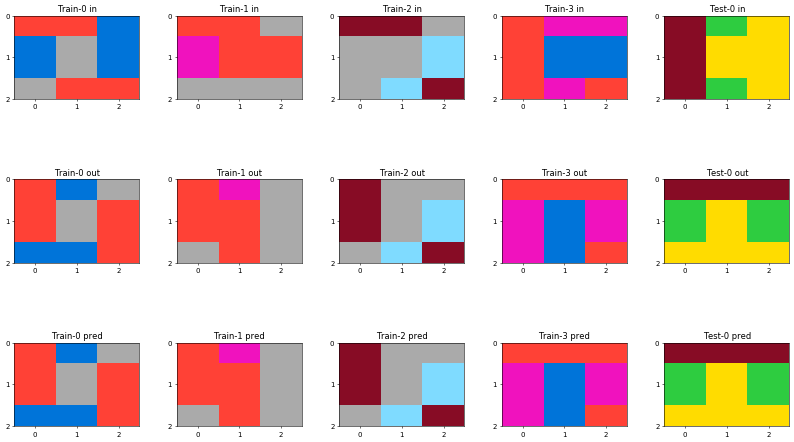

In [18]:
start_time = time.time()
print("Testing DSL Coverage (Manual) ...")

def combine_tasks(a):
    b = a.copy()
    #print(b)
    b = rotate_1(b)
    b = flip_1(b)
    return b

tasks_indices = [178]
for task in tasks_indices:
    check_p(train_task_data[task], combine_tasks)

print("--- %s seconds ---" % (time.time() - start_time))

In [19]:
task_n = 178
train_data = build_trainlist(train_task_data[task_n])
test_data = build_testlist(train_task_data[task_n])
task_data = Task(train_data, test_data)

In [20]:
gen = generate_programs(task_data)

diffs dict_keys(['color_changed', 'color_perc_changed', 'shape_changed'])
{'color_changed': -1, 'color_perc_changed': -1, 'shape_changed': -1}


In [21]:
select_programs(task_data, gen)

best_programs [([<function rotate_1 at 0x11f4ddf80>, <function rotate_1 at 0x11f4ddf80>], 0), ([<function rotate_1 at 0x11f4ddf80>, <function rotate_2 at 0x11f5250e0>], 0), ([<function rotate_1 at 0x11f4ddf80>, <function rotate_3 at 0x11f525200>], 0), ([<function rotate_1 at 0x11f4ddf80>, <function flip_1 at 0x11f525170>], 4), ([<function rotate_1 at 0x11f4ddf80>, <function flip_2 at 0x11f525440>], 0), ([<function rotate_2 at 0x11f5250e0>, <function rotate_1 at 0x11f4ddf80>], 0), ([<function rotate_2 at 0x11f5250e0>, <function rotate_2 at 0x11f5250e0>], 0), ([<function rotate_2 at 0x11f5250e0>, <function rotate_3 at 0x11f525200>], 0), ([<function rotate_2 at 0x11f5250e0>, <function flip_1 at 0x11f525170>], 0), ([<function rotate_2 at 0x11f5250e0>, <function flip_2 at 0x11f525440>], 0), ([<function rotate_3 at 0x11f525200>, <function rotate_1 at 0x11f4ddf80>], 0), ([<function rotate_3 at 0x11f525200>, <function rotate_2 at 0x11f5250e0>], 0), ([<function rotate_3 at 0x11f525200>, <functi